<a href="https://colab.research.google.com/github/hariszaf/dingo/blob/dingo_tutorial/dingo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  `dingo` : A python library for metabolic networks sampling and analysis


## About this Colab notebook 

Aim of this notebook is to highlight the importance of metabolic networks analysis and the insight it may provide, as well as to demonstrate how to use the `dingo` Python library for the analysis of metabolic networks.  


For your convenience, we suggest to make a copy of the notebook 
by saving this notebook on your Google Drive 

(`File > Save a copy in Drive`). 

This way you can change things on the notebook, and make your own experiments as you like!

* The `&> /dev/null` in the end of a command is so you do not see all the messages returned when the command is executed.
* The `%%capture` is a flag so Google Colab not to prin the output of the chunk of code in a cell. We have used it in some cases to avoid long warning messages. 

In case an error comes up when running a notebook's command, you may click 

`Runtime > Factory reset runtime` 

and run the notebook from scratch.

### Installation 

Regarding installation of `dingo` you may either follow the instructions described above or those described on [GitHub](https://github.com/GeomScale/dingo). In the latter, we use the [`poetry`](https://github.com/GeomScale/dingo) tool for dependency management and packaging of Python packages.
Here we don't. 

In case you will follow the instruction described here, you need to remember that when working on a normal console (terminal) you will have to remove any `!` and `%` characters from the begining of the following commands; these allow to Google Colab work as a terminal console. 

**Requirements:**

* a Unix like environment, e.g Linux, MacOS etc.
* a computer machine with at least 4GB of RAM; `dingo` requires about 4GB to compile 

## Introduction

### Genome scale metabolic network reconstruction

🧬 🧬 Over the last decades, vast amounts of data have been gathered mostly thanks to the High Throuput technologies developed. 

As a result, the complete sequencing of a bacterial (strain) **genome** is now considered trivial. 

Global efforts have lead to large databases supporting the **annotation** of the genes found in a genome.


<img src='https://drive.google.com/uc?id=1v-BnN3Rsnc8_UuLTUo2rwGvP9oUWvcYW' height=350>
<img src='https://drive.google.com/uc?id=1D62Xxc_X5DRW5naMfY6rCyLm4v98FXMC' height=350>

From the genome annotation we can now get the **enzymes** and therefore, the **reactions** that potentially take place in our strain (along with their stoichiometry).

<img src='https://drive.google.com/uc?id=1_vuamqeEzjvJMw5_hR4XuLnjj0KJn1x0' height=200 wirth=300>
<img src='https://drive.google.com/uc?id=1sw7nCeVJQfIc6oiDCGvfKFIqXg_so3Eb' height="200" width=250>

And from the sum of the reactions present, along with their corresponding constraints, we can now get the metabolic network of the species. 
Thus, we have now software tools that enable automatic genome-scale reconstructions (e.g. [carveme](https://carveme.readthedocs.io/en/latest/))

The corresponding metabolic model is the *mathematical representation* of what happens in the organism along with the intaractions between it and its environmnet. Here is a toy example:

<img src='https://drive.google.com/uc?id=1x20oGpf8ACikdAR7lxAORNfw8QFPwCom'>

And here is what metabolic networks allow us to see! 

In [ ]:
#@title Pathway reactions fluxes representation{ display-mode: "form" }
from IPython.display import HTML
HTML('<video width="40%" height="25%" loop autoplay><source src="https://gibbons-lab.github.io/isb_course_2020/micom/assets/fluxes.mp4" type="video/mp4"></video>')



This GIFF is from a [presentation](https://gibbons-lab.github.io/isb_course_2020/micom/) from Christian Diener at Gibbons Lab!
  🤓 

### Metabolic networks analysis

Now that we do have a metabolic model, the question is *how could someone investigate its properties?*

So, from each metabolic model we can get a stoichiometric matrix ($S$) of the reactions that take place in the organism along with their corresponding constraints. 
As you can guess, $S$ is nothing but a matrix with $m$ metabolites and $n$ reactions!

$S_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$

Where each line is a **metabolite** and each column a **reaction**. 

Considering our system is at steady state, the flux through each reaction is given by the following equation: 

$Sv = 0$ 

which defines a system of linear equations. 

The solution space for that system is a **polytope**; a geometric object with "flat" sides that lives in a large number of dimensions. 

<img src="https://drive.google.com/uc?id=1CF_XbO5w89E6hXDXotNuApQXylfWRW5P" height=350>


**Flux Balance Analysis (FBA)** is commonly used to identify an optimal flux distribution by optimizing a linear objective function; e.g the biomass value of the organism. You may see more about FBA [here](https://www.nature.com/articles/nbt.1614/).


<img src="https://drive.google.com/uc?id=1gxKIvpFOpfHdJ4YCA5OlMzDmgyEU72KU">

Figure from: [Libourel, I. G., & Shachar-Hill, Y.. Annu. Rev. Plant Biol. 59 (2008)](10.1146/annurev.arplant.58.032806.103822)


**Flux Variability Analysis (FVA)** evaluates the minimum and maximum range of each reaction flux that can still satisfy the constraints of the metabolic model. 

To this end FVA uses a double linear programming problem, a maximization and a subsequent minimization for each reaction.

<img src="https://drive.google.com/uc?id=1xL66uYMTxRvM4qjrqYbQhxGqrvOLn27z" height=300>

Figure by a presentation of [Lizbeth Hampton](https://slideplayer.com/slide/13509212/).

Both FBA and FVA are biased methods as they require an objective function and they return either a single or a pair of flux values respectively. 
**Flux sampling** on the other hand is an unbiased method for metabolic network analysis, providing a thorough description of the potential values a flux might get, along with the probability to get it. 

Our goal is to perform **uniform sampling** on this solution space (also called **flux space**) to gain an unbiased overview of the model's global features but also to investigate how the model responses in various situations. 

However, sampling can be a rather challenging task both from the computational and the geometical point of view. 

💪 To this end, `dingo` makes use of the [Multiphase Monte Carlo Sampling algorithm (MMCS)](https://drops.dagstuhl.de/opus/volltexte/2021/13798/pdf/lipics-vol189-socg2021-complete.pdf) developed by the [GeomScale Org.](https://geomscale.github.io/) too. 

💪 Our method splits sampling in phases and makes use of **rounding** steps; this way it is both efficient and returns high quality samples. 


<img src="https://drive.google.com/uc?id=1QsrAuRc3f7KpldevzqHy4I1-7y_Lx6Vn">
  

In addition, the MMCS algorithm uses an optimized variant of Billiard Walk with faster arithmetic complexity per step. 

Here is an example of how a new point is found. 


<img src="https://drive.google.com/uc?id=15M4J6qiJnFl7T-WgUTentVdyhoeN4_85" height= 200>

<img src="https://drive.google.com/uc?id=1ApFtNGqEpe3lWugJnbZ9SL4pGPnOD6zj" height= 200>

<img src="https://drive.google.com/uc?id=1adYF5SUZMDbFTrj0zet-kMeqFgsVqfWA" height= 200>


<img src="https://drive.google.com/uc?id=1v3zcJQ4Nj4jdUpKESDdmP-zrOBxGOJpf" height= 200>

<img src="https://drive.google.com/uc?id=1HU30rfJoC8nmrlv_Ibblmygh_ZL6KoHN" height= 200>



<img src="https://drive.google.com/uc?id=1MmuZgNMQajqSufiHRUgJh3x--L77jAd4" height= 200>




Finally, the modular design of the method enables the use of any random walk.


-------------------------------------------------

## Get and install *dingo*

Here we will see how to install `dingo` and all its dependecies manually. 
However, you can also install `dingo` via `poetry`; for more you may see [here](https://github.com/GeomScale/dingo).

Install the dependencies for PySPQR library; for debian/ubuntu linux run:

In [ ]:
!apt-get install libsuitesparse-dev &> /dev/null
!pip install sparseqr &> /dev/null
!pip install Cython &> /dev/null

Get the `dingo` repo.

In [ ]:
!git clone https://github.com/GeomScale/dingo.git

Cloning into 'dingo'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 141 (delta 58), reused 65 (delta 16), pack-reused 16
Receiving objects: 100% (141/141), 181.31 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (58/58), done.


To load the submodules that `dingo` uses, run:

In [ ]:
%cd dingo/
!git submodule update --init

/content/dingo
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'eigen'
Submodule 'volume_approximation' (https://github.com/TolisChal/volume_approximation.git) registered for path 'volume_approximation'
Cloning into '/content/dingo/eigen'...
Cloning into '/content/dingo/volume_approximation'...
Submodule path 'eigen': checked out '53a7864c48a2b2fc226c69e9184d7cc8e6b36b6d'
Submodule path 'volume_approximation': checked out 'facbe630f435d187416e34f5dcfa5e391c54105a'


Then, download and unzip the `boost` library:

In [ ]:
!wget -O boost_1_76_0.tar.bz2 https://boostorg.jfrog.io/artifactory/main/release/1.76.0/source/boost_1_76_0.tar.bz2 &> /dev/null
!tar xjf boost_1_76_0.tar.bz2 &> /dev/null
!rm boost_1_76_0.tar.bz2 &> /dev/null

Install `dingo`

The following command will install `dingo` and it will take a while to compile. 

Remember that about 4GB of RAM are required to do so. 

In [ ]:
!python setup.py install --user &> /dev/null
print('dingo is ready to go!')

dingo is ready to go!


We have made some tests for you so you can make sure `dingo` has been installed properly.

You may have a look at these [test files](https://github.com/GeomScale/dingo/tree/develop/tests) so you can run `dingo` from your terminal.

In [ ]:
%%capture
!python tests/unit_tests.py

Remember that in order for `dingo` to perform the best way possible, you need to get the `gurobi` solver. 

To do so, you need to get the solver by running:

`
pip3 install -i https://pypi.gurobi.com gurobipy
`

and download a (academic) [license](https://www.gurobi.com/downloads/end-user-license-agreement-academic/). 

--------------------------------------------------------------------------

The following command is to make Colab have access to the `dingo` library that was just compiled. 
This will be probably **no need for you**. 
In case Python does not find `dingo`, just check the 
semifinal line on the complilation step, in this case:

`Writing /root/.local/lib/python3.7/site-packages/dingo-0.1.0.egg-info`

This is the path where `dingo` was compiled. 

In [ ]:
import sys
_ = (sys.path.append("/root/.local/lib/python3.7/site-packages/"))

-------------------------------------------------------------------------------

## Run `dingo` to analyse your metabolic network

Now we know that our Python console has been installed fine, we may ipmort `dingo`! 

In [ ]:
import dingo

Let us now have a look about how we can use `dingo`

The `ess` stands for the effective sample size (ESS) (default value is `1000`) and the `psrf` is a flag to request an upper bound equal to `1.1` for the value of the *potential scale reduction factor* (PSRF) of each marginal flux (default option is `False`).

In [ ]:
from dingo import MetabolicNetwork

model = MetabolicNetwork.from_json('dingo/ext_data/e_coli_core.json')

Let's see what the model consists from. 

First of all, let's see the metabolites ($m$) included in our model. 
Here is the first 10 of them. 

In [ ]:
print('Number of metabolites in my model: ', len(model.metabolites))
print('Here are the first 10 metabolites in your model: ', model.metabolites[:9])

Number of metabolites in my model:  72
Here are the first 10 metabolites in your model:  ['adp_c', 'atp_c', 'f6p_c', 'fdp_c', 'h_c', 'accoa_c', 'coa_c', 'for_c', 'pyr_c']


And now, let us have a look in the reactions ($n$) that occur. 
Again, here is the first 10 reactions. 

In [ ]:
print('Number of reactions in my model: ', len(model.reactions))
print('Here are the first 10 reactions in your model: ', model.reactions[:9])

Number of reactions in my model:  95
Here are the first 10 reactions in your model:  ['PFK', 'PFL', 'PGI', 'PGK', 'PGL', 'ACALD', 'AKGt2r', 'PGM', 'PIt2r']


Moreover, let us see the stoichiometrix matrix ($S$) of our model.

In [ ]:
model.S

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

And its dimensions are of course $m*n$.

In [ ]:
model.S.shape

(72, 95)

Last but not least, let us have a look at the **biomass** or **objective function** of our model. 

In [ ]:
model.biomass_function

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

As you can see, this array has only a single `1` in index `24`.
Let's see which function is this. 

In [ ]:
model.reactions[24]

'BIOMASS_Ecoli_core_w_GAM'

Ok, so what exactly is the biommas function? 🤔 

Let's print the `24` column of our $S$ matrix to see what we have there.

In [ ]:
# We import numpy and set the threshold parameter to max to enable the display of all the elements of the array
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
model.S[:,24]

And just to make sure, let's print the length of this array too. 

In [ ]:
model.S[:,24].shape

(72,)

As expected, the length of the biomass array equals to the number of the metabolites of our model. 

In [ ]:
len(model.metabolites)

72

Moreover, you need to remember that the indexes of those 2 arrays are in order, meaning that the actual biomass function would be as follows:

$ 59.81*adp\_c - 59.81*atp\_c -0.0709*f6p\_c + ...  -0.8977*r5p\_c$

You can also have a look on the `dingo` related parameters of the model you just built.

In [ ]:
model.parameters

{'distribution': 'uniform',
 'fast_computations': False,
 'nullspace_method': 'sparseQR',
 'opt_percentage': 100}

### Run `dingo` to sample the flux space of your model

Once your `model` is set, you can go sampling using the [`PolytopeSampler`](https://github.com/GeomScale/dingo/blob/a76b4be22f33feac86dff38746c7f2706afb2b67/dingo/PolytopeSampler.py#L28) class of `dingo`. 

So, you first build an instance of this class based on your `model`

In [ ]:
from dingo import PolytopeSampler
sampler = PolytopeSampler(model)

and then you run the `generate_steady_states` method of it. 

The [`generate_steady_states`](https://github.com/GeomScale/dingo/blob/a76b4be22f33feac86dff38746c7f2706afb2b67/dingo/PolytopeSampler.py#L119) method can be used with no arguments, i.e.

`steady_states = sampler.generate_steady_states()`

In the command we run in the following cell though, we use both the two parameters the method can get: 

* the **effective sample size (ESS)** asked (by default `ESS = 1000`). ESS is the number of effectively independent draws from the posterior distribution that the Markov chain is equivalent to.
 
* the **Potential Scale Reduction Factor (PSRF)** of each marginal flux to  
 get an upper bound equal to 1.1 (by default that is set as `False`)

In [ ]:
%%capture
steady_states = sampler.generate_steady_states(ess = 1000, psrf = True) # this took a little bit more than 5 minutes

Now that we have our samples, let's have a closer look to some of them!

What we actually did is that we computed a great number of values of the flux of each reaction given that our system is always at a steady state. 

That means that we now have a **flux distribution** (all the values computed for the flux of a specif reaction) for each reaction of our model!

Obviously, we have as many flux distributions as the reactions of our model:

In [ ]:
print('Number of reactions in my model: ', len(model.reactions))
print('Number of flux distributions sampled: ', steady_states.shape[0])

Number of reactions in my model:  95
Number of flux distributions sampled:  95


And each flux distribution has as many flux values as `dingo` required to reach the ESS asked. 

In [ ]:
print('Number of flux values of the flux distributions returned: ', steady_states.shape[1])

Let us now assume that we are interested in a certain reaction of our model, for example the last reaction of the glycolysis which is catalyzed by the Pyruvate kinase (PYK) enzyme. 

We first need to look in the `model.reactions` list and find the index of the `PYK` reaction; the enzyme is usually the name of reaction. 

In [ ]:
model.reactions.index('PYK')

23

Now that we know the index of the reaction of our interest, we can use the [`plot_histogram`](https://github.com/GeomScale/dingo/blob/a76b4be22f33feac86dff38746c7f2706afb2b67/dingo/utils.py#L177) function of `dingo` to plot its corresponding flux distribution. 

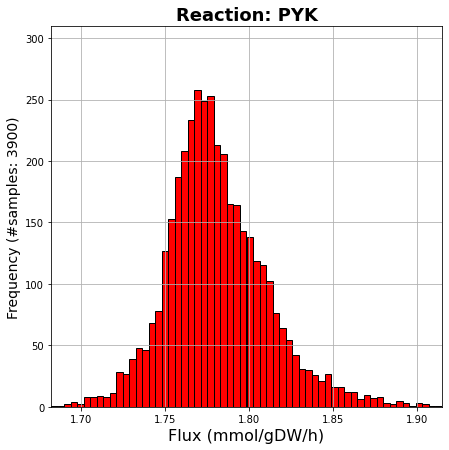

In [ ]:
from dingo import plot_histogram

reactions = model.reactions
plot_histogram(
        steady_states[23],  # here we set which reaction's flux we need to get 
        reactions[23],      # here we provide the name of the reaction
        n_bins = 60,
)

From the flux distribution of PYK we can that it has a range of values between 1.7 and 1.9 and that it follows the normal distribution, with a mean value at 1.775 mmol/gDW/h (millimoles per gram dry weight per hour).


Applications of flux sampling can provide great insight in many ways. 

Based on the [iAB-AMØ-1410](https://doi.org/10.1038/msb.2010.68) genome-scale metabolic model of human alveolar macrophages and the SARS-CoV-2 virus biomass objective function (VBOF) they built, [Renz et al. (2020)](https://doi.org/10.1093/bioinformatics/btaa813) investigated for alterations in the metabolism to come up with potential antiviral targets. 

In line with the findings of Renz et al. (2020), flux sampling in the metabolic model built from the macrophage model and the VBOF using `dingo` indicates **guanylate kinase (GK1)** as a potential antiviral target. 
Flux sampling was perfored first with no objective function for the virus and then after maximizing the VBOF built by Renz et al. (2020). 

<img src="https://drive.google.com/uc?id=1IOdSscVP0HoTRctQuSCywgIXokUNE-_v" height=400>



### Run FBA with `dingo`

Again, to perform FBA with `dingo`, you just need to call the according method ([`fba`](https://github.com/GeomScale/dingo/blob/a76b4be22f33feac86dff38746c7f2706afb2b67/dingo/MetabolicNetwork.py#L107)) of the `model` you built using the [`MetabolicNetwork`](https://github.com/GeomScale/dingo/blob/a76b4be22f33feac86dff38746c7f2706afb2b67/dingo/MetabolicNetwork.py#L21) class. 

FBA is a lot easier both from the computational and the geometical point of view and it takes much less time. 

In [ ]:
%%capture
fba_output = model.fba()

As already mentioned, FBA identifies an **optimal** flux distribution by optimizing a linear **objective function**.

So the output of FBA can be considered as a single sample of the flux sampling method described above. Thus, if we check on the output this time we will see that it has 2 attributes:
* the **flux vector** (meaning the set of the reactions flux values in the same solution) when the objective function maximizes.
* the **flux value** that the objective function gets when it is maximun

In [ ]:
numpy.set_printoptions(threshold=None)

max_biomass_flux_vector = fba_output[0]
max_biomass_objective = fba_output[1]

print('This is the optimal flux vector according to the biomass objective function: ', max_biomass_flux_vector)
print('----------')
print('This is the value of that optimal solution of the objective function: ', max_biomass_objective)

💪 Even it is quite common that the objective function is the biomass function of a model, **you can change your objective function** as you wish and use any reaction as your objective function.

For example, to maximize the 1st reaction of the model, we first build an array with the number of reactions of our model with `0`s and then we set only its first elemet equal to `1`:

In [ ]:
import numpy as np
n = model.num_of_reactions()
obj_fun = np.zeros(n)
obj_fun[0] = 1

Now we can replace the `biomass_function` parameter of our model with our new objective function

In [ ]:
model.biomass_function = obj_fun

And if we know ask to see our new objective function: 

In [ ]:
model.biomass_function

You see that the `1` is now not in the `24` index but in the first. 🎉

So if we run now a FBA here is what we will get. 

In [ ]:
%%capture
fba_output_new_obj = model.fba()

In [ ]:
max_biomass_flux_vector_new_obj = fba_output_new_obj[0]
max_biomass_objective_new_obj = fba_output_new_obj[1]
print('This is the optimal flux vector according to my objective function: ', max_biomass_flux_vector_new_obj)
print('----------')
print('This is the value of that optimal solution of the new objective function: ', max_biomass_objective_new_obj)

### Run FVA with `dingo` 

As we said earlier, FVA gets the min and max value of each reaction flux that can still satisfy the constraints of the metabolic model.

**Remember!** 

In the previous step, we replaced the `biomass_function` of our model. So if we run FVA in our current model, then the first reaction of our model 

In [ ]:
model.reactions[0]

will be used as the objective function!

Let's run FVA using that; this will take a while 😉

In [ ]:
%%capture
# Run FVA
fva_output = model.fva()

# Get min and max flux values
pfk_min_fluxes = fva_output[0]
pfk_max_fluxes = fva_output[1]

# Get the max flux distribution and the max biomass value when the objective function is maximum
pfk_max_biomass_flux_vector = fva_output[2]
pfk_max_biomass_objective = fva_output[3]

We can go with that or if we need to go back in using the actual biomass function of our model, we can either do the same process as before to change again the `biomass_function` or we can just build a new instance of the `MetabolicNetwork` class. 

In [ ]:
%%capture
# Build new instance of the model
new_model = MetabolicNetwork.from_json('ext_data/e_coli_core.json')

# Run FVA
fva_output = new_model.fva()

# Get min and max flux values
min_fluxes = fva_output[0]
max_fluxes = fva_output[1]

# Get the max flux distribution and the max biomass value when the objective function is maximum
max_biomass_flux_vector = fva_output[2]
max_biomass_objective = fva_output[3]

Let's see how they're different!

In [ ]:
print('This is the flux vector with the minimum values of each flux when the PFK reaction gets maximum: ', pfk_min_fluxes)
print('This is the flux vector with the minimum values of each flux when the biomass function gets maximum: ', min_fluxes)

print('----------')

print('This is the flux vector with the maximum values of each flux when the PFK reaction gets maximum: ', pfk_max_fluxes)
print('This is the flux vector with the maximum values of each flux when the biomass function gets maximum: ', max_fluxes)

Appanrently (and obviously) they are quite different!

The same thing is with the flux vector and the max biomas objective.

In [ ]:
print('This is the optimal flux vector according to the PFK reaction as objective function: \n', pfk_max_biomass_flux_vector)
print('This is the optimal flux vector according to the biomass as objective function: \n', max_biomass_flux_vector)


print('\n----------\n')

print('This is value of the optimal solution when PFK is the objective function: ', pfk_max_biomass_objective)
print('This is value of the optimal solution when biomass is the objective function: ', max_biomass_objective)

This way, someone can investigate how a metabolic network responds under different circumstances. 

We hope you will find `dingo` usefull and easy-to-use! 

For anything might be needed, don't hesitate to [open an issue](https://github.com/GeomScale/dingo/issues) on the project's GitHub repo!

## Run `dingo` at the community level

Just like in the case of a single metabolic network, when a community is under study, `dingo` uses 2 main classes; the `CommunityMetabolicNetwork`
and the `CommunityPolytopeSampler`. To sapmle the flux space of a series of metabolic networks (we will call this set a "community") you will have to provide the path to a directory with all the models of your community and those alone.


In [ ]:
from dingo import CommunityMetabolicNetwork
from dingo import CommunityPolytopeSampler

path  = os.getcwd() + "/community_models/"
model = CommunityMetabolicNetwork.buildModelList(path, "json")
sampler = CommunityPolytopeSampler(model)
steady_states = sampler.generate_steady_states()

You may also run the same analysis from a terminal, by running the following command

In [ ]:
# format could be either json or mat
 python -m dingo -cmd  path_to_dir_with_models  --format json

## References

* Palsson Bernhard. [Systems biology](https://www.cambridge.org/core/books/systems-biology/7F8445BC87019806B3625DFC4B5C27D4). Cambridge university press, 2015. 

* Orth Jeffrey D., Ines Thiele, and Bernhard Ø. Palsson. ["What is flux balance analysis?."](https://doi.org/10.1038/nbt.1614) Nature biotechnology 28.3 (2010): 245-248.

*  Chalkis Apostolos, Fisikopoulos Vissarion, Tsigaridas Elias and Zafeiropoulos Haris ["Geometric Algorithms for Sampling the Flux Space of Metabolic Networks"](https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf)

* Schellenberger, Jan, and Bernhard Ø. Palsson. ["Use of randomized sampling for analysis of metabolic networks."](https://doi.org/10.1074/jbc.R800048200) Journal of biological chemistry 284, no. 9 (2009): 5457-5461.

## The GeomScale Org. project

[Geomscale Org](https://geomscale.github.io/) is a research and development 
project that delivers open source code for state-of-the-art algorithms at the intersection of data science, optimization, geometric, and statistical computing. 

`dingo` is based on the `volesti` package; an open source project, [C++ library](https://github.com/GeomScale/volume_approximation) for volume approximation and sampling of convex bodies.

GeomScale is part of [NumFOCUS](https://numfocus.org/) and a Google Summer of Code [(GSoC) organization](https://summerofcode.withgoogle.com/organizations/5553085268623360/). 

<br/>

<img src="https://drive.google.com/uc?id=1PTSnQi7ev1Dv0BwffvFWz4jT5zdtCmqL" height=200>
